In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
import warnings
from IPython.display import SVG
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import Adam, Nadam, SGD, RMSprop


In [ ]:
#Load dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/All_sqli_dummy.csv")
df = df[df['Label'].notna()]
df = df[df['Sentence'].notna()]
df.head(5)

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,create user name identified by pass123 tempora...,1
2,%29,1
3,' AND 1 = utl_inaddr.get_host_address ( ( S...,1
4,select * from users where id = '1' or @ @1 = ...,1


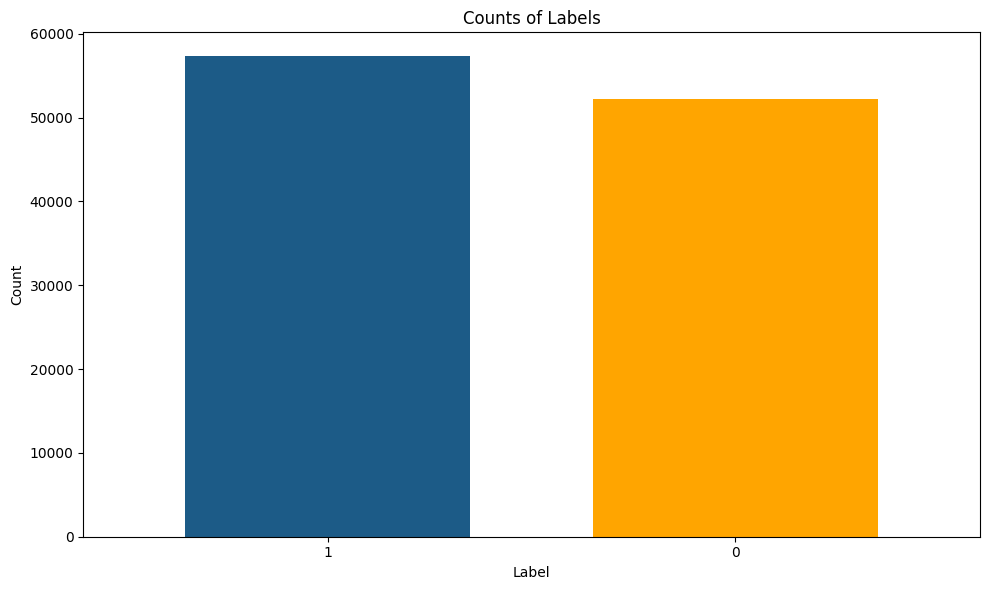

Count of each label:
1    57310
0    52208
Name: Label, dtype: int64


In [ ]:
# Filtering out rows with NaN values in 'Label' and 'Sentence' columns
df = df[df['Label'].notna()]
df = df[df['Sentence'].notna()]

# Counting the occurrences of each label
label_counts = df['Label'].value_counts()

# Define colors for each class
colors = {'1': '#1c5b87', '0': 'orange'}

# Creating a bar plot with reduced distance between bars
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=[colors[str(label)] for label in label_counts.index], width=0.7)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of Labels')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Count data based on 'Label' column
label_counts = df['Label'].value_counts()

print("Count of each label:")
print(label_counts)

In [ ]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#.........text to number function........

In [ ]:
def data2char_index(X, max_len):
    alphabet = " abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
    result = []
    for data in X:
        mat = []
        for ch in data:
            ch = ch.lower()
            if ch not in alphabet:
                continue
            mat.append(alphabet.index(ch))
        result.append(mat)
    X_char = tf.keras.preprocessing.sequence.pad_sequences(np.array(result, dtype=object), padding='post',
                                                           truncating='post', maxlen=max_len)
    return X_char

In [ ]:
#........Data pre-processing

In [ ]:
#Data pre-processing

data = df['Sentence'].values
label = df['Label'].values

data = data2char_index(data, max_len=1000)

x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

print(x_train.shape)
print(y_train.shape)

(88709, 1000)
(88709,)


# Deep Learning

In [ ]:
#.................CNN model 1.................

In [ ]:
def model_v1(max_len):
    main_input = tf.keras.layers.Input(shape=(max_len,))

    embedder = tf.keras.layers.Embedding(
        input_dim=70,
        output_dim=80,
        input_length=max_len,
        trainable=False
    )
    embed = embedder(main_input)

    cnn1 = tf.keras.layers.Conv1D(32, 5, padding='same', strides=1, activation='relu')(embed)
    cnn1 = tf.keras.layers.MaxPooling1D(pool_size=12)(cnn1)

    cnn2 = tf.keras.layers.Conv1D(32, 10, padding='same', strides=1, activation='relu')(embed)
    cnn2 = tf.keras.layers.MaxPooling1D(pool_size=11)(cnn2)

    cnn3 = tf.keras.layers.Conv1D(32, 15, padding='same', strides=1, activation='relu')(embed)
    cnn3 = tf.keras.layers.MaxPooling1D(pool_size=10)(cnn3)

    cnn = tf.keras.layers.concatenate([cnn1, cnn2, cnn3], axis=1)
    flat = tf.keras.layers.Flatten()(cnn)
    drop = tf.keras.layers.Dropout(0.2)(flat)
    dense1 = tf.keras.layers.Dense(1024, activation='relu')(drop)
    dense2 = tf.keras.layers.Dense(128, activation='relu')(dense1)
    main_output = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
    model = tf.keras.Model(inputs=main_input, outputs=main_output)
    return model

In [ ]:
#......Hybrid network model 2 (CNN hybrid GRU)................

In [ ]:
def model_v2(max_len):

    main_input = tf.keras.layers.Input(shape=(max_len,))

    embedder = tf.keras.layers.Embedding(
        input_dim=70,
        output_dim=80,
        input_length=max_len,
        trainable=False
    )
    embed = embedder(main_input)

    cnn1 = tf.keras.layers.Conv1D(32, 3, padding='same', strides=1, activation='relu')(embed)
    cnn1 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn1)

    cnn2 = tf.keras.layers.Conv1D(64, 3, padding='same', strides=1, activation='relu')(cnn1)
    cnn2 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn2)

    cnn3 = tf.keras.layers.Conv1D(128, 3, padding='same', strides=1, activation='relu')(cnn2)
    cnn3 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn3)
    flat1 = tf.keras.layers.Flatten()(cnn3)

    GRU0 = tf.keras.layers.GRU(32, return_sequences=False, return_state=False)(embed)
    flat2 = tf.keras.layers.Flatten()(GRU0)


    concatenate = tf.keras.layers.concatenate([flat1,flat2], axis=1)
    dense1 = tf.keras.layers.Dense(512, activation='relu')(concatenate)
    drop = tf.keras.layers.Dropout(0.5)(dense1)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(drop)
    main_output = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
    model = tf.keras.Model(inputs=main_input, outputs=main_output)
    return model

In [ ]:
#.....Hybrid network model 3 (CNN hybrid LSTM)

In [ ]:
def model_v3(max_len):

    main_input = tf.keras.layers.Input(shape=(max_len,))

    embedder = tf.keras.layers.Embedding(
        input_dim=70,
        output_dim=70,
        input_length=max_len,
        trainable=False
    )
    embed = embedder(main_input)

    cnn1 = tf.keras.layers.Conv1D(32, 3, padding='same', strides=1, activation='relu')(embed)
    cnn1 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn1)

    cnn2 = tf.keras.layers.Conv1D(64, 3, padding='same', strides=1, activation='relu')(cnn1)
    cnn2 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn2)

    cnn3 = tf.keras.layers.Conv1D(128, 3, padding='same', strides=1, activation='relu')(cnn2)
    cnn3 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn3)

    cnn4 = tf.keras.layers.Conv1D(256, 3, padding='same', strides=1, activation='relu')(cnn3)
    cnn4 = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn4)

    flat1 = tf.keras.layers.Flatten()(cnn3)

    LSTM0 = tf.keras.layers.LSTM(64)(embed)

    concatenate = tf.keras.layers.concatenate([flat1,LSTM0], axis=1)
    dense1 = tf.keras.layers.Dense(512, activation='relu')(concatenate)
    drop = tf.keras.layers.Dropout(0.5)(dense1)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(drop)
    main_output = tf.keras.layers.Dense(1, activation='sigmoid')(dense2)
    model = tf.keras.Model(inputs=main_input, outputs=main_output)
    return model


In [ ]:
#..................Bidirectional LSTM7

In [ ]:
def model_v4(max_len):

    main_input = tf.keras.layers.Input(shape=(max_len,))
    embedder = tf.keras.layers.Embedding(
        input_dim=70,
        output_dim=70,
        input_length=max_len,
        trainable=False
    )
    embed = embedder(main_input)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(embed)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(main_input, outputs)
    model.summary()
    return model

In [ ]:

model = model_v3(max_len=1000)
optimizer = Nadam(learning_rate=0.001)
model.compile(optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1000)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1000, 70)             4900      ['input_3[0][0]']             
                                                                                                  
 conv1d_8 (Conv1D)           (None, 1000, 32)             6752      ['embedding_2[0][0]']         
                                                                                                  
 max_pooling1d_8 (MaxPoolin  (None, 500, 32)              0         ['conv1d_8[0][0]']            
 g1D)                                                                                       

In [ ]:
history_log= model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
2773/2773 [==============================] - 118s 40ms/step - loss: 6.1988 - accuracy: 0.5646 - val_loss: 7.3175 - val_accuracy: 0.5201
Epoch 2/10
2773/2773 [==============================] - 109s 39ms/step - loss: 7.2562 - accuracy: 0.5242 - val_loss: 7.3175 - val_accuracy: 0.5201
Epoch 3/10
2773/2773 [==============================] - 109s 39ms/step - loss: 7.2562 - accuracy: 0.5242 - val_loss: 7.3175 - val_accuracy: 0.5201
Epoch 4/10
2773/2773 [==============================] - 110s 40ms/step - loss: 7.2562 - accuracy: 0.5242 - val_loss: 7.3175 - val_accuracy: 0.5201
Epoch 5/10
2773/2773 [==============================] - 109s 39ms/step - loss: 7.2562 - accuracy: 0.5242 - val_loss: 7.3175 - val_accuracy: 0.5201
Epoch 6/10
2773/2773 [==============================] - 110s 40ms/step - loss: 7.2562 - accuracy: 0.5242 - val_loss: 7.3175 - val_accuracy: 0.5201
Epoch 7/10
2773/2773 [==============================] - 110s 40ms/step - loss: 2.2058 - accuracy: 0.8409 - val_loss: 0

In [ ]:
pred = model.predict(x_test)
y_pred = np.int64(pred > 0.5)

print("")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(" Accuracy: {0} \n Precision: {1} \n Recall: {2} \n F1 Score: {3}".format(accuracy, precision, recall, f1))


343/343 [==============================] - 6s 16ms/step

 Accuracy: 0.9811906501095691 
 Precision: 0.9722413793103448 
 Recall: 0.9920830401125967 
 F1 Score: 0.9820619993033786


In [ ]:
# Extracting validation accuracy and loss from the training history
val_accuracy = history_log.history['val_accuracy']
val_loss = history_log.history['val_loss']

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print("\nValidation Accuracy: {0} \nValidation Loss: {1}".format(val_accuracy[-1], val_loss[-1]))
print("Test Accuracy: {0} \nTest Loss: {1}".format(test_accuracy, test_loss))


343/343 [==============================] - 6s 16ms/step - loss: 0.2863 - accuracy: 0.9812

Validation Accuracy: 0.9823475480079651 
Validation Loss: 0.2670402228832245
Test Accuracy: 0.9811906218528748 
Test Loss: 0.2863377332687378


In [ ]:
# Plot the training accuracy and validation accuracy
plt.figure(figsize=(15, 5))

# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_log.history['accuracy'], label='Training Accuracy')
plt.plot(history_log.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(history_log.history['loss'], label='Training Loss')
plt.plot(history_log.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout

3423/3423 [==============================] - 162s 47ms/step


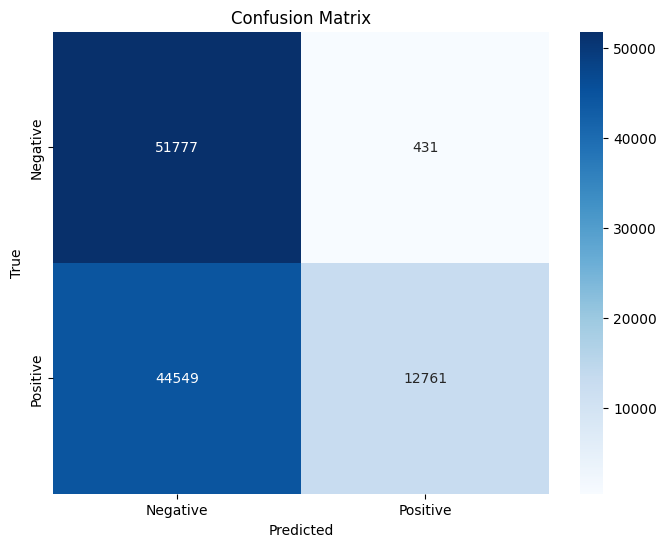

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.99      0.70     52208
           1       0.97      0.22      0.36     57310

    accuracy                           0.59    109518
   macro avg       0.75      0.61      0.53    109518
weighted avg       0.76      0.59      0.52    109518



In [ ]:
import seaborn as sns
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming you have trained your model using model.fit()

# Predict on the test data
y_pred = model.predict(data)

# Convert the probabilities to binary predictions
y_pred_binary = np.round(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(label, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report
print("Classification Report:")
print(classification_report(label, y_pred_binary))


In [ ]:
#..........ROC Curve................

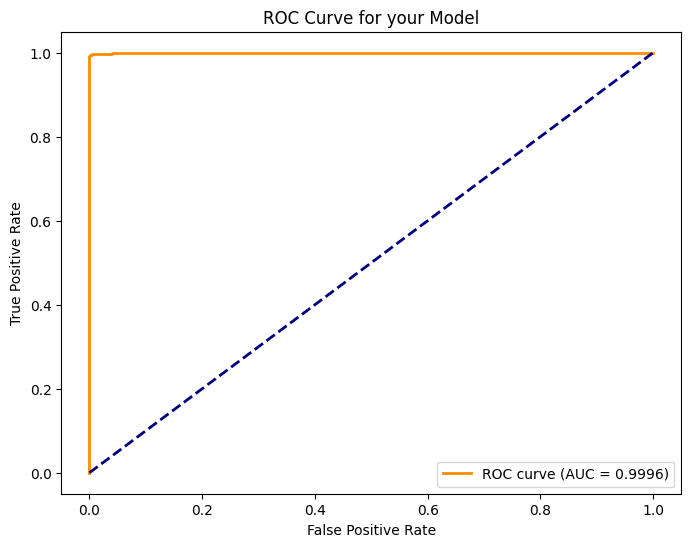

Area Under ROC Curve (AUC): 0.9996


In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate true positive rate (TPR) and false positive rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Calculate AUC score
auc = roc_auc_score(y_test, pred)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr,color='darkorange',lw=2, label='ROC curve (AUC = {:.4f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for your Model')
plt.legend()
plt.show()

# (Optional) Print AUC score
print("Area Under ROC Curve (AUC): {:.4f}".format(auc))


# Machine Learning

In [ ]:
#Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier()

# Train the Decision Tree Classifier on the training data
dt_clf.fit(x_train, y_train)

# Make predictions on the test data
y_pred = dt_clf.predict(x_test)

# Calculate and display various performance metrics
print(f"Accuracy of Decision Tree on test set : {accuracy_score(y_test, y_pred)}")
print(f"F1 Score of Decision Tree on test set : {f1_score(y_test, y_pred)}")

# Generate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate elements of the confusion matrix
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# Calculate Sensitivity (Recall)
sensitivity = TP / float(TP + FN)
print(f"Sensitivity: {sensitivity}")

# Calculate Specificity
specificity = TN / float(TN + FP)
print(f"Specificity: {specificity}")

# Calculate Precision
precision = TP / float(TP + FP)
print(f"Precision: {precision}")

# Optionally, you can calculate F1 score using Precision and Sensitivity (Recall)
F1 = 2 * ((precision * sensitivity) / (precision + sensitivity))
print(f"F1 Score: {F1}")

recall = recall_score(y_test, y_pred)
print(" Recall : {0}".format(recall))

Accuracy of Decision Tree on test set : 0.9169101533966398
F1 Score of Decision Tree on test set : 0.9203988803358993
Sensitivity: 0.9127342123525329
Specificity: 0.9215497301464919
Precision: 0.9281933662667607
F1 Score: 0.9203988803358993
 Recall : 0.9127342123525329


Epoch 1/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.3989 - accuracy: 0.8641 - val_loss: 0.3421 - val_accuracy: 0.8971
Epoch 2/10
2218/2218 [==============================] - 14s 6ms/step - loss: 0.3385 - accuracy: 0.8936 - val_loss: 0.3246 - val_accuracy: 0.9060
Epoch 3/10
2218/2218 [==============================] - 17s 8ms/step - loss: 0.3192 - accuracy: 0.9013 - val_loss: 0.3040 - val_accuracy: 0.9095
Epoch 4/10
2218/2218 [==============================] - 12s 6ms/step - loss: 0.3072 - accuracy: 0.9059 - val_loss: 0.2998 - val_accuracy: 0.9122
Epoch 5/10
2218/2218 [==============================] - 13s 6ms/step - loss: 0.2948 - accuracy: 0.9083 - val_loss: 0.2863 - val_accuracy: 0.9175
Epoch 6/10
2218/2218 [==============================] - 10s 4ms/step - loss: 0.2870 - accuracy: 0.9123 - val_loss: 0.2952 - val_accuracy: 0.9149
Epoch 7/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.2755 - accuracy: 0.9158 - val_loss: 0.2834 - val_ac

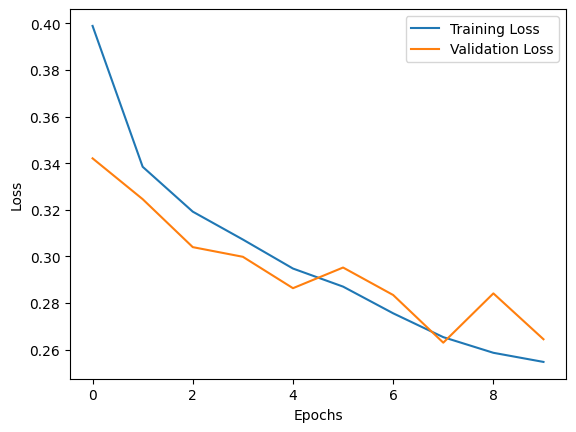

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming x_train, x_test, y_train, y_test are your features and labels
# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Split the data into training and validation sets
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train_scaled, y_train, test_size=0.2, random_state=42
)

# Define a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Optionally, you can plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
2218/2218 [==============================] - 15s 7ms/step - loss: 0.2438 - accuracy: 0.9250 - val_loss: 0.2590 - val_accuracy: 0.9222
Epoch 2/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.2389 - accuracy: 0.9260 - val_loss: 0.2757 - val_accuracy: 0.9232
Epoch 3/10
2218/2218 [==============================] - 11s 5ms/step - loss: 0.2357 - accuracy: 0.9270 - val_loss: 0.2685 - val_accuracy: 0.9246
Epoch 4/10
2218/2218 [==============================] - 10s 4ms/step - loss: 0.2313 - accuracy: 0.9291 - val_loss: 0.2556 - val_accuracy: 0.9217
Epoch 5/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.2246 - accuracy: 0.9311 - val_loss: 0.2575 - val_accuracy: 0.9242
Epoch 6/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.2205 - accuracy: 0.9321 - val_loss: 0.2502 - val_accuracy: 0.9271
Epoch 7/10
2218/2218 [==============================] - 10s 4ms/step - loss: 0.2161 - accuracy: 0.9334 - val_loss: 0.2624 - val_ac

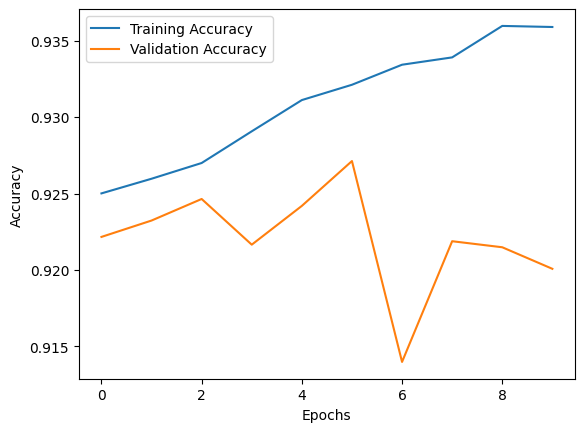

In [ ]:
# Train the model
history = model.fit(x_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


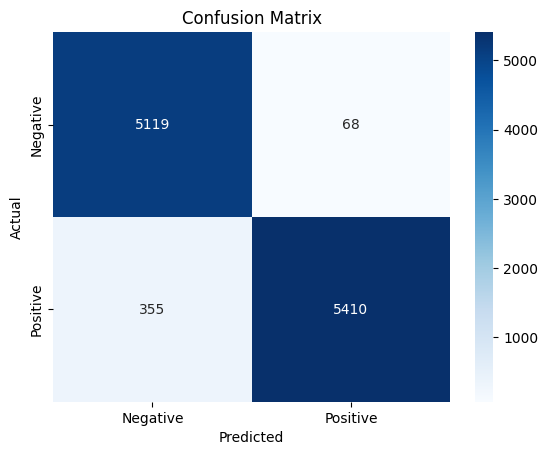

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
labels = ['Negative', 'Positive']
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

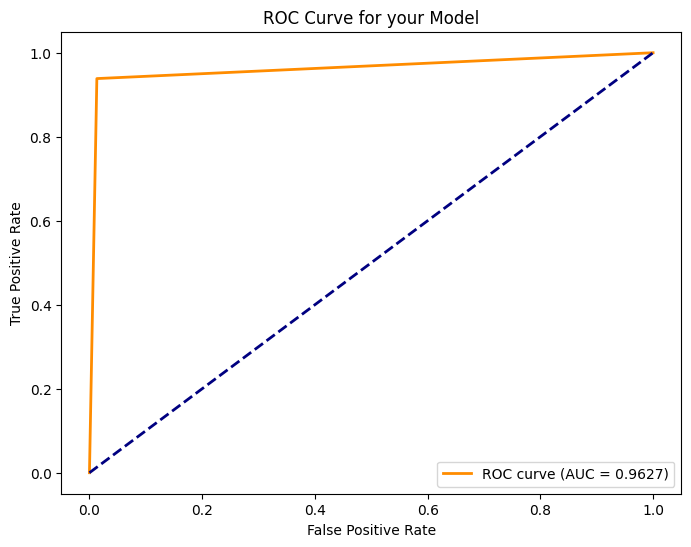

Area Under ROC Curve (AUC): 0.9627


In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate true positive rate (TPR) and false positive rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred)

# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate true positive rate (TPR) and false positive rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for your Model')
plt.legend(loc='lower right')  # Move the legend to the bottom right corner
plt.show()


# (Optional) Print AUC score
print("Area Under ROC Curve (AUC): {:.4f}".format(auc))

In [ ]:
#Random Forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier()

# Train the Random Forest Classifier on the training data
rf_clf.fit(x_train, y_train)

# Make predictions on the test data
y_pred = rf_clf.predict(x_test)

# Calculate and display various performance metrics
print(f"Accuracy of Random Forest on test set : {accuracy_score(y_test, y_pred)}")
print(f"F1 Score of Random Forest on test set : {f1_score(y_test, y_pred)}")

# Generate the confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Calculate elements of the confusion matrix
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

# Calculate Sensitivity (Recall)
sensitivity = TP / float(TP + FN)
print(f"Sensitivity: {sensitivity}")

# Calculate Specificity
specificity = TN / float(TN + FP)
print(f"Specificity: {specificity}")

# Calculate Precision
precision = TP / float(TP + FP)
print(f"Precision: {precision}")

# Optionally, you can also calculate F1 score using Precision and Sensitivity (Recall)
F1 = 2 * ((precision * sensitivity) / (precision + sensitivity))
print(f"F1 Score: {F1}")

recall = recall_score(y_test, y_pred)
print(" Recall : {0}".format(recall))

Accuracy of Random Forest on test set : 0.9606464572680788
F1 Score of Random Forest on test set : 0.9611956423876834
Sensitivity: 0.9361627499123115
Specificity: 0.9872380952380952
Precision: 0.9876040703052729
F1 Score: 0.9611956423876834
 Recall : 0.9361627499123115


Epoch 1/10
2218/2218 [==============================] - 11s 5ms/step - loss: 0.4057 - accuracy: 0.8623 - val_loss: 0.3362 - val_accuracy: 0.8975
Epoch 2/10
2218/2218 [==============================] - 11s 5ms/step - loss: 0.3412 - accuracy: 0.8930 - val_loss: 0.3310 - val_accuracy: 0.8934
Epoch 3/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.3229 - accuracy: 0.8989 - val_loss: 0.2983 - val_accuracy: 0.9111
Epoch 4/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.3094 - accuracy: 0.9048 - val_loss: 0.3040 - val_accuracy: 0.9046
Epoch 5/10
2218/2218 [==============================] - 10s 4ms/step - loss: 0.2965 - accuracy: 0.9101 - val_loss: 0.2913 - val_accuracy: 0.9154
Epoch 6/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.2894 - accuracy: 0.9109 - val_loss: 0.2831 - val_accuracy: 0.9191
Epoch 7/10
2218/2218 [==============================] - 14s 6ms/step - loss: 0.2785 - accuracy: 0.9152 - val_loss: 0.2723 - val_ac

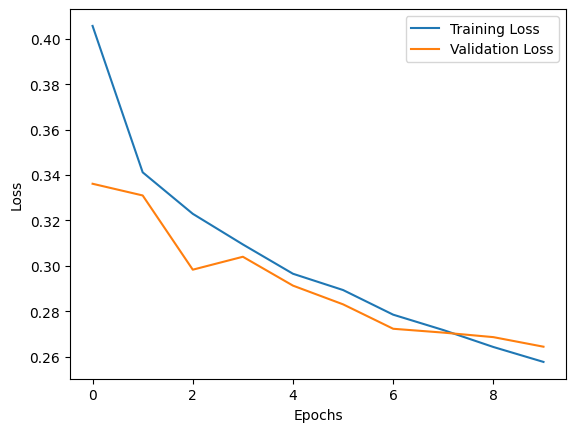

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming x_train, x_test, y_train, y_test are your features and labels
# Standardize the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Split the data into training and validation sets
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train_scaled, y_train, test_size=0.2, random_state=42
)

# Define a simple neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Optionally, you can plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.2511 - accuracy: 0.9246 - val_loss: 0.2520 - val_accuracy: 0.9251
Epoch 2/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.2448 - accuracy: 0.9262 - val_loss: 0.2460 - val_accuracy: 0.9203
Epoch 3/10
2218/2218 [==============================] - 10s 4ms/step - loss: 0.2398 - accuracy: 0.9269 - val_loss: 0.2445 - val_accuracy: 0.9257
Epoch 4/10
2218/2218 [==============================] - 12s 6ms/step - loss: 0.2376 - accuracy: 0.9275 - val_loss: 0.2573 - val_accuracy: 0.9227
Epoch 5/10
2218/2218 [==============================] - 12s 5ms/step - loss: 0.2296 - accuracy: 0.9306 - val_loss: 0.2567 - val_accuracy: 0.9242
Epoch 6/10
2218/2218 [==============================] - 10s 5ms/step - loss: 0.2260 - accuracy: 0.9319 - val_loss: 0.2376 - val_accuracy: 0.9233
Epoch 7/10
2218/2218 [==============================] - 11s 5ms/step - loss: 0.2230 - accuracy: 0.9318 - val_loss: 0.2475 - val_ac

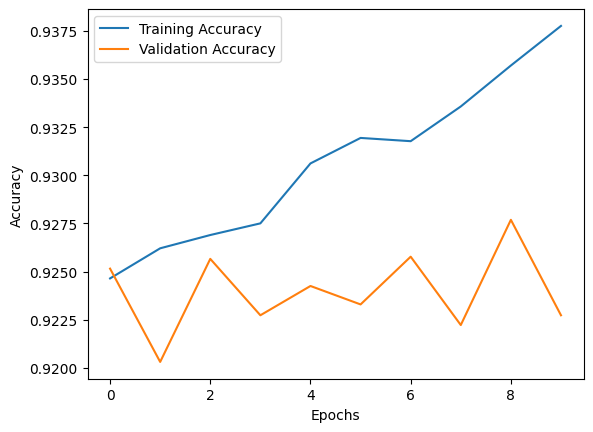

In [ ]:
# Train the model
history = model.fit(x_train_split, y_train_split, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test_scaled, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


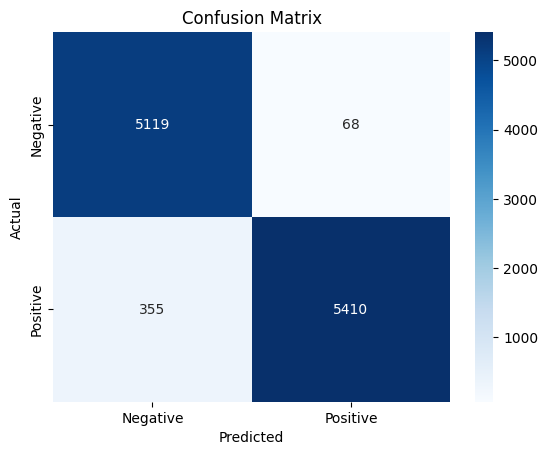

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
labels = ['Negative', 'Positive']
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

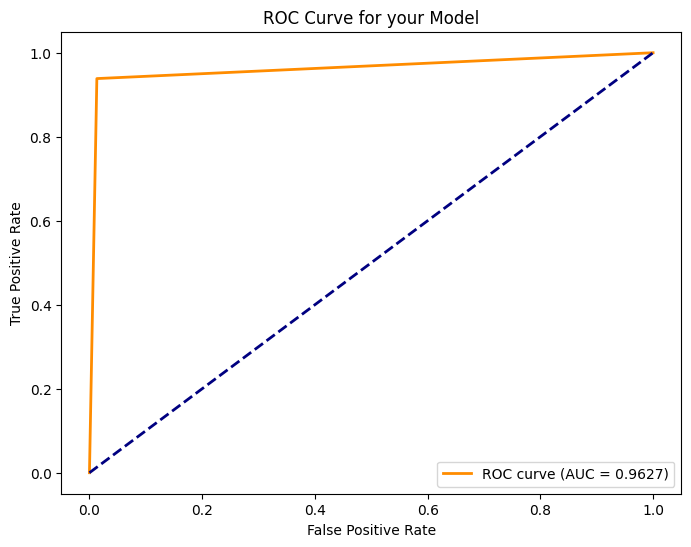

Area Under ROC Curve (AUC): 0.9627


In [ ]:
# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate true positive rate (TPR) and false positive rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred)

# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate true positive rate (TPR) and false positive rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC score
auc = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for your Model')
plt.legend(loc='lower right')  # Move the legend to the bottom right corner
plt.show()


# (Optional) Print AUC score
print("Area Under ROC Curve (AUC): {:.4f}".format(auc))

# Comparison

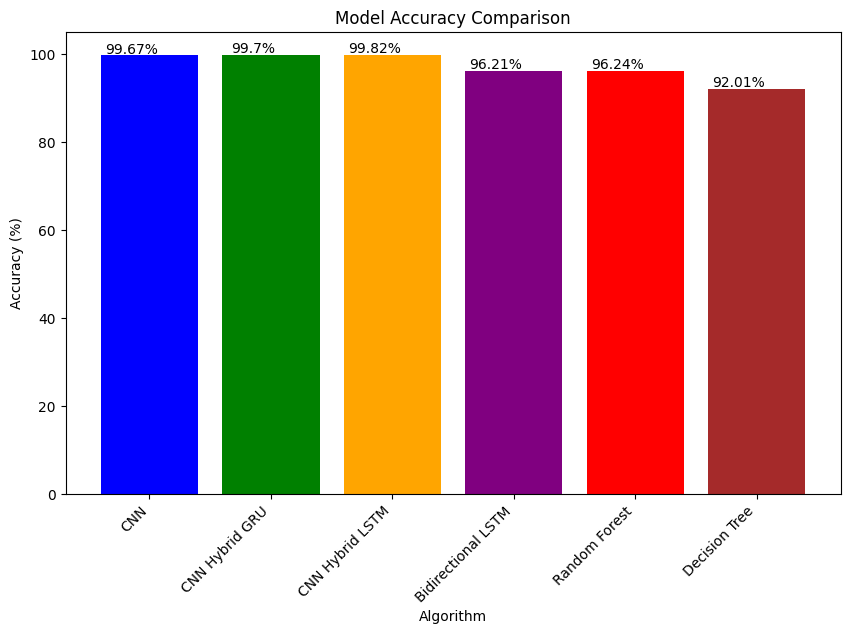

In [ ]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracies
models = ['CNN', 'CNN Hybrid GRU', 'CNN Hybrid LSTM', 'Bidirectional LSTM', 'Random Forest', 'Decision Tree']
accuracies = [99.67, 99.70, 99.82, 96.21, 96.24, 92.01]

# Plotting the bar chart with rotated x-axis labels
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'purple', 'red', 'brown'])

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

# Add data labels on top of the bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15, bar.get_height() + 0.5, f'{accuracy}%', ha='center', color='black')

plt.xlabel('Algorithm')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 105)  # Set the y-axis range for better visualization
plt.show()


# Confusion Matrix

CNN

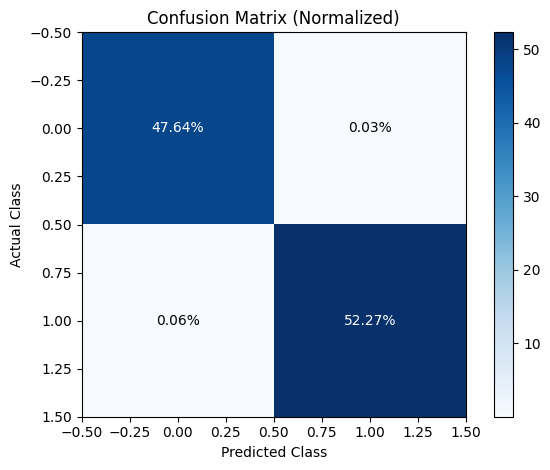

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
cm = np.array([[52177, 31],
               [61, 57249]])

# Normalize the matrix for percentages
cm_percentage = cm / cm.sum() * 100

# Create a figure and axis
fig, ax = plt.subplots()

# Create the heatmap
ax.imshow(cm_percentage, cmap='Blues')

# Add colorbar
plt.colorbar(ax.imshow(cm_percentage, cmap='Blues'))

# Set labels and title
ax.set_title('Confusion Matrix (Normalized)')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')

# Set ticks and labels for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Set font color to black for white background or white for black background
        font_color = 'black' if cm_percentage[i, j] < 40 else 'white'
        ax.text(j, i, f"{cm_percentage[i, j]:.2f}%", ha='center', va='center', color=font_color)

# Show the plot
plt.tight_layout()
plt.show()


CNN hybrid GRU

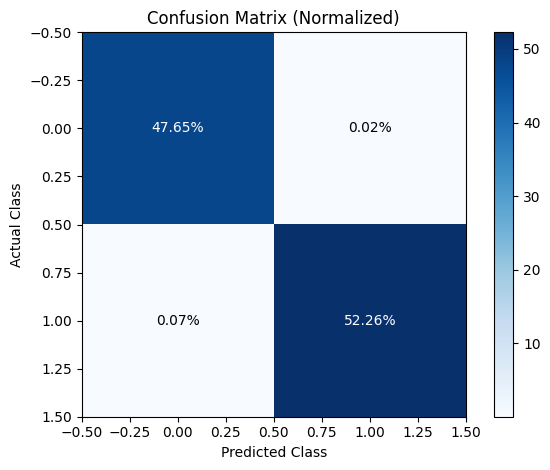

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
cm = np.array([[52187, 21],
               [72, 57238]])

# Normalize the matrix for percentages
cm_percentage = cm / cm.sum() * 100

# Create a figure and axis
fig, ax = plt.subplots()

# Create the heatmap
ax.imshow(cm_percentage, cmap='Blues')

# Add colorbar
plt.colorbar(ax.imshow(cm_percentage, cmap='Blues'))

# Set labels and title
ax.set_title('Confusion Matrix (Normalized)')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')

# Set ticks and labels for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Set font color to black for white background or white for black background
        font_color = 'black' if cm_percentage[i, j] < 40 else 'white'
        ax.text(j, i, f"{cm_percentage[i, j]:.2f}%", ha='center', va='center', color=font_color)

# Show the plot
plt.tight_layout()
plt.show()


CNN hybrid LSTM

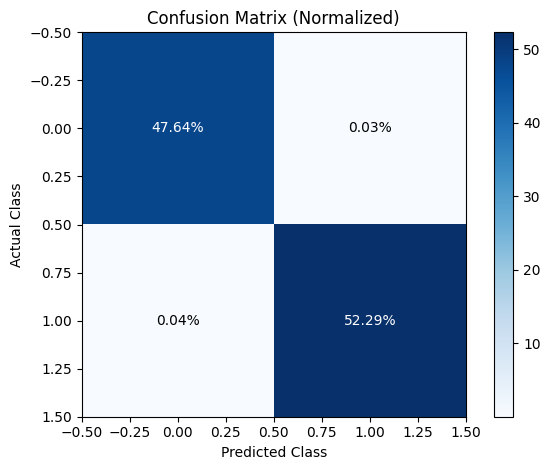

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
cm = np.array([[52175, 33],
               [42, 57268]])

# Normalize the matrix for percentages
cm_percentage = cm / cm.sum() * 100

# Create a figure and axis
fig, ax = plt.subplots()

# Create the heatmap
ax.imshow(cm_percentage, cmap='Blues')

# Add colorbar
plt.colorbar(ax.imshow(cm_percentage, cmap='Blues'))

# Set labels and title
ax.set_title('Confusion Matrix (Normalized)')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')

# Set ticks and labels for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Set font color to black for white background or white for black background
        font_color = 'black' if cm_percentage[i, j] < 40 else 'white'
        ax.text(j, i, f"{cm_percentage[i, j]:.2f}%", ha='center', va='center', color=font_color)

# Show the plot
plt.tight_layout()
plt.show()


Bidirectional LSTM

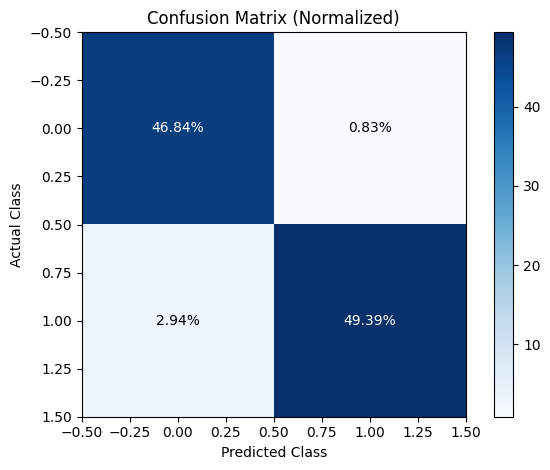

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
cm = np.array([[51296, 912],
               [3215, 54095]])

# Normalize the matrix for percentages
cm_percentage = cm / cm.sum() * 100

# Create a figure and axis
fig, ax = plt.subplots()

# Create the heatmap
ax.imshow(cm_percentage, cmap='Blues')

# Add colorbar
plt.colorbar(ax.imshow(cm_percentage, cmap='Blues'))

# Set labels and title
ax.set_title('Confusion Matrix (Normalized)')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')

# Set ticks and labels for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Set font color to black for white background or white for black background
        font_color = 'black' if cm_percentage[i, j] < 40 else 'white'
        ax.text(j, i, f"{cm_percentage[i, j]:.2f}%", ha='center', va='center', color=font_color)

# Show the plot
plt.tight_layout()
plt.show()


Random Forrest

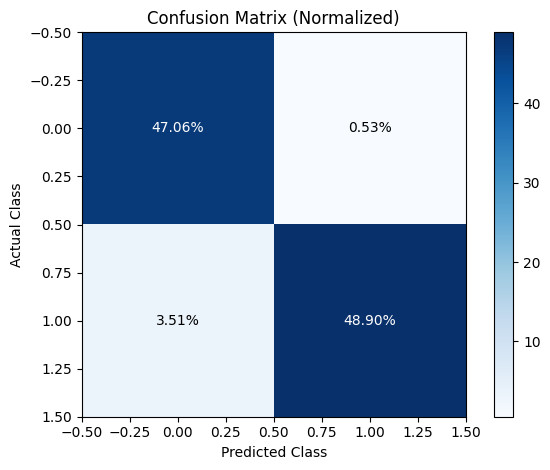

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
cm = np.array([[5154, 58],
               [384, 5356]])

# Normalize the matrix for percentages
cm_percentage = cm / cm.sum() * 100

# Create a figure and axis
fig, ax = plt.subplots()

# Create the heatmap
ax.imshow(cm_percentage, cmap='Blues')

# Add colorbar
plt.colorbar(ax.imshow(cm_percentage, cmap='Blues'))

# Set labels and title
ax.set_title('Confusion Matrix (Normalized)')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')

# Set ticks and labels for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Set font color to black for white background or white for black background
        font_color = 'black' if cm_percentage[i, j] < 40 else 'white'
        ax.text(j, i, f"{cm_percentage[i, j]:.2f}%", ha='center', va='center', color=font_color)

# Show the plot
plt.tight_layout()
plt.show()


Decision Tree

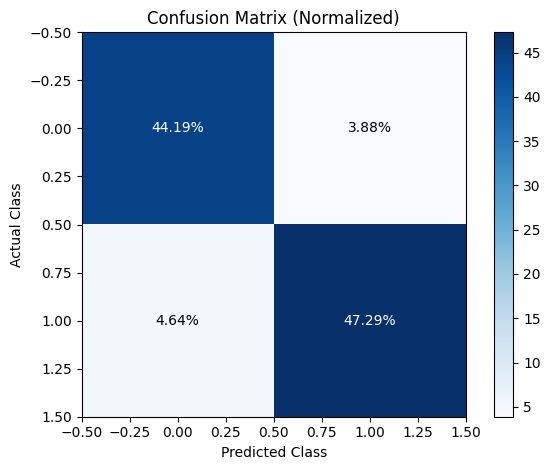

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
cm = np.array([[4840, 425],
               [508, 5179]])

# Normalize the matrix for percentages
cm_percentage = cm / cm.sum() * 100

# Create a figure and axis
fig, ax = plt.subplots()

# Create the heatmap
ax.imshow(cm_percentage, cmap='Blues')

# Add colorbar
plt.colorbar(ax.imshow(cm_percentage, cmap='Blues'))

# Set labels and title
ax.set_title('Confusion Matrix (Normalized)')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')

# Set ticks and labels for each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        # Set font color to black for white background or white for black background
        font_color = 'black' if cm_percentage[i, j] < 40 else 'white'
        ax.text(j, i, f"{cm_percentage[i, j]:.2f}%", ha='center', va='center', color=font_color)

# Show the plot
plt.tight_layout()
plt.show()
